# ANN for regression, exercise project 1 - Diamonds

## Dependancies

In [177]:
# pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

In [178]:
df = pd.read_csv("data/diamonds.csv")

In [179]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [180]:
df = df.drop("Unnamed: 0", axis=1)

In [181]:
df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

## Categorial variables

The dataset appears to have a few categorial variables, but looking at the notes of the original uploader of the dataset, it is implied that they are ordinal categories.

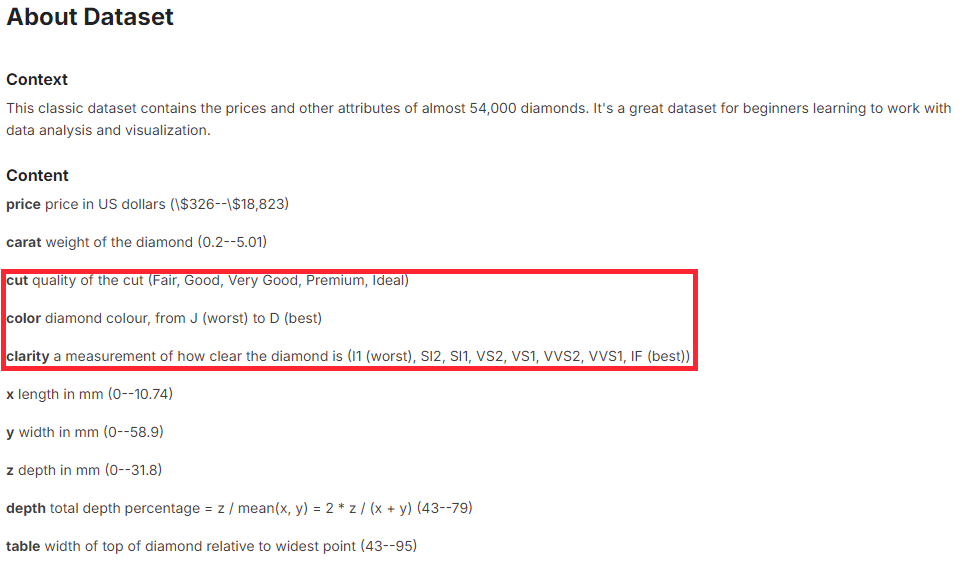

In [182]:
df['cut'].value_counts()

cut
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: count, dtype: int64

In [183]:
df['color'].value_counts()

color
G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: count, dtype: int64

In [184]:
df['clarity'].value_counts()

clarity
SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: count, dtype: int64

In [185]:
# Defining the map function
def binary_map_cut(x):
    return x.map({"Fair": 0, "Good": 1, "Very Good": 2, "Premium":3, "Ideal":4})

# Defining the map function
def binary_map_color(x):
    return x.map({"J": 0, "I": 1, "H": 2, "G": 3, "F":4, "E":5, "D":6})

# Defining the map function
def binary_map_clarity(x):
    return x.map({"I1":0, "SI2":1,"SI1":2,"VS2":3,"VS1":4,"VVS2":5,"VVS1":6,"IF":7})

# Applying the function to the housing list
df[["cut"]] = df[["cut"]].apply(binary_map_cut)
df[["color"]] = df[["color"]].apply(binary_map_color)
df[["clarity"]] = df[["clarity"]].apply(binary_map_clarity)

In [186]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,4,5,1,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,5,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,5,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,1,3,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,0,1,63.3,58.0,335,4.34,4.35,2.75


## Scaling the values

In [187]:
# num_vars = ['carat', 'cut', 'color', 'clarity', 'depth', 'table','price','x','y','z']

# from sklearn.preprocessing import MinMaxScaler
# scaler_with_price = MinMaxScaler()
# df[num_vars] = scaler_with_price.fit_transform(df[num_vars])

## Creating the regression model

In [188]:
# printing out the column names for easier copying for X/y
df.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

In [189]:
# define independent variable
X = df[['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y','z']]

# define dependant variable
y = df['price']

In [190]:
# unfortunately the scikit-learn's train_test_split doesn't support validation
# set split in itself.
# if you want to split the test set into two for a validation set too, try this trick:

# first, train/test split => 70% for training, 30% for other purposes (temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=101)

# now, split the 30% for other purposes by 50% (resulting in 2 x 15%)
# so finally, we have:
# 70% for training
# 15% for testing
# 15% for validation
# => 70 + 15 +15 = 100%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=101)

In [191]:
variable_amount = len(X.columns)

In [192]:
# just seeing how much data we have in each
print(f"Train data amount: {len(X_train)}")
print(f"Test data amount: {len(X_test)}")
print(f"Validation data amount: {len(X_val)}")

Train data amount: 37758
Test data amount: 8091
Validation data amount: 8091


### First Model

Let's try to make it simple and only set high node counts first.

In [193]:
# Define Sequential neural network model
# modify the input shape to match your training column count
# remember, one of the columns is removed from training columns
# to be the target value. so if your data originally had 10 columns
# the input shape is 9 ... (10 - 1 => 9)
# the input layer itself can have a different number of nodes
# Tip: have at least the same number of nodes as in the input shape
# output layer in regression is always 1 node without activation function
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu", input_shape=(variable_amount,)),  # 1st layer with 64 neurons
        layers.Dropout(0.1),  # Add dropout to avoid overfitting
        layers.Dense(128, activation="relu"),  # 2nd layer with more neurons to learn complex patterns
        layers.Dropout(0.1),  # Dropout again
        layers.Dense(64, activation="relu"),  # 3rd layer reduces neuron count
        layers.Dense(1)  # Output layer for regression
    ]
)

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
model.compile(optimizer='adam', loss='mse')

# common tips on how to change neural network structure if your metrics are not good:

# make wider (or narrower) layers (for example, 64 or 128 nodes)
# make a longer or shorter network (add or remove layers)
# use Dropout -layers (e.g. layers.Dropout(0.1))

# remember: there's no process or mathematical formula
# in order to figure out the optimal neural network structure
# it's mostly all about trial and error => EXPERIMENTATION!

# remember to have enough "decision-space" for your data!
# it's highly unlikely a dataset with 20 different variables is going
# to work well with only 8 nodes in each layer etc.

# print out the summary of your model
model.summary()

c:\Users\Startklar\Documents\Study\Finnilandi\DeepLearning\DPierdiluca_DL-Repo\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,281 (67.50 KB)

 Trainable params: 17,281 (67.50 KB)

 Non-trainable params: 0 (0.00 B)

In [166]:
model.fit(x=X_train, y=y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0215 - val_loss: 0.0017
Epoch 2/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 3/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 4/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 5/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 6/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 7/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 8/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 9/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 10/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 11/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 12/50
1180/1180 ━━━━━━━━

<Axes: >

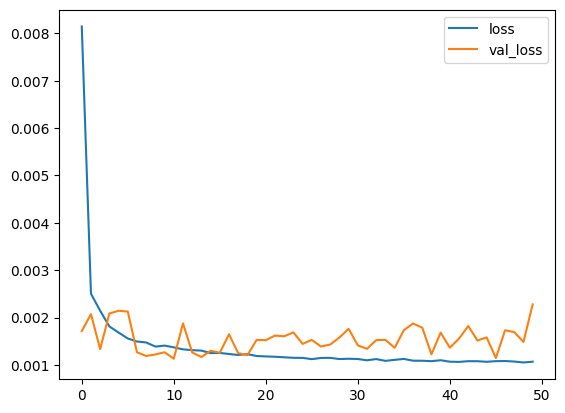

In [167]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [168]:
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
0.0023113538045436144

Train data evaluation:
0.002216159598901868


In [169]:
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,Test True Y,Model Predictions
0,0.166568,0.233058
1,0.611180,0.585344
2,0.995567,0.845242
3,0.105909,0.158437
4,0.017408,0.043216
...,...,...
8086,0.089690,0.125230
8087,0.008055,0.041160
8088,0.109477,0.142372
8089,0.033465,0.086108


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

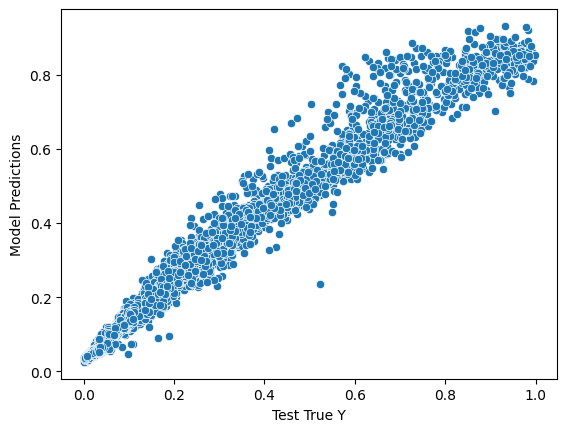

In [170]:
# these values follow a linear line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

According to the scatterplot: the more expensive the diamonds get, the less accurate the predictions get. This does make some sense, since the higher the price range, the less people seem to care about the actual quality details.

In [171]:
 # MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
0.04 $

MSE
0.0 $^2

RMSE:
0.05 $

R-squared:
0.95

Explained variance score:
0.97


C:\Users\Startklar\AppData\Local\Temp\ipykernel_79584\3124900743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


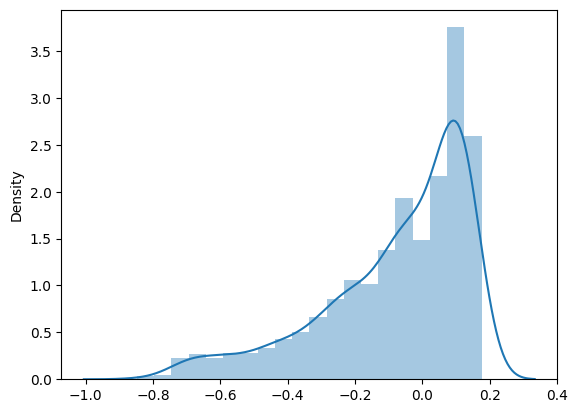

In [172]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

In [173]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.006237,1.00,0.833333,0.142857,0.513889,0.230769,0.000000,0.367784,0.067572,0.076415
1,0.002079,0.75,0.833333,0.285714,0.466667,0.346154,0.000000,0.362197,0.065195,0.072642
2,0.006237,0.25,0.833333,0.571429,0.386111,0.423077,0.000054,0.377095,0.069100,0.072642
3,0.018711,0.75,0.166667,0.428571,0.538889,0.288462,0.000433,0.391061,0.071817,0.082704
4,0.022869,0.25,0.000000,0.142857,0.563889,0.288462,0.000487,0.404097,0.073854,0.086478


In [174]:
# let's try with some new imaginary data
# this example uses the student performance index score dataset
# modify this as needed regarding your own dataset
tester_row = {
            'carat':    0.25,
            'cut' :      3,
            'color':      3,
            'clarity' :   4,
            'depth' :     68.6, # => 2 * z / (x + y) * 100
            'table'  :    62.5,
            'x'   :       4.1,
            'y'  :        4.15,
            'z' :         2.83
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

In [175]:
result = model.predict(tester_row)[0]

print()
print(f"Estimated price for this diamond:")
print(f"{round(float(result[0]), 2)} $")
print("----------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Estimated price for this diamond:
-2.27 $
----------------


In [176]:
len(y_test)

8091

## Second Model

The first model already seems to be very accurate, let's try to add a few regularizers and batch normalization.

In [101]:
# Define Sequential neural network model
# modify the input shape to match your training column count
# remember, one of the columns is removed from training columns
# to be the target value. so if your data originally had 10 columns
# the input shape is 9 ... (10 - 1 => 9)
# the input layer itself can have a different number of nodes
# Tip: have at least the same number of nodes as in the input shape
# output layer in regression is always 1 node without activation function
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(variable_amount,)),
        layers.Dense(64, activation="relu"),  # 1st layer with 64 neurons
        layers.Dropout(0.1),  # Add dropout to avoid overfitting
        layers.Dense(128, activation="relu"),  # 2nd layer with more neurons to learn complex patterns
        layers.Dropout(0.1),  # Dropout again
        layers.Dense(64, activation="relu"),  # 3rd layer reduces neuron count
        layers.Dense(1)  # Output layer for regression
    ]
)

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
model.compile(optimizer='adam', loss='mse')

# common tips on how to change neural network structure if your metrics are not good:

# make wider (or narrower) layers (for example, 64 or 128 nodes)
# make a longer or shorter network (add or remove layers)
# use Dropout -layers (e.g. layers.Dropout(0.1))

# remember: there's no process or mathematical formula
# in order to figure out the optimal neural network structure
# it's mostly all about trial and error => EXPERIMENTATION!

# remember to have enough "decision-space" for your data!
# it's highly unlikely a dataset with 20 different variables is going
# to work well with only 8 nodes in each layer etc.

# print out the summary of your model
model.summary()

c:\Users\Startklar\Documents\Study\Finnilandi\DeepLearning\DPierdiluca_DL-Repo\.venv\lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_7           │ (None, 9)              │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,317 (67.64 KB)

 Trainable params: 17,299 (67.57 KB)

 Non-trainable params: 18 (72.00 B)

In [102]:
model.fit(x=X_train, y=y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 11433150.0000 - val_loss: 1407041.6250
Epoch 2/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1989115.3750 - val_loss: 1290371.0000
Epoch 3/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1938671.6250 - val_loss: 1290073.0000
Epoch 4/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1953283.1250 - val_loss: 1224094.0000
Epoch 5/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1910000.3750 - val_loss: 1119645.0000
Epoch 6/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1746272.6250 - val_loss: 1135185.5000
Epoch 7/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1769359.2500 - val_loss: 1073098.3750
Epoch 8/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1740984.7500 - val_loss: 1044321.6250
Epoch 9/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1737090.7500 - val_loss: 1151326.0000
Epoch 10/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1708310.3750 - val_loss: 1000066.500

<Axes: >

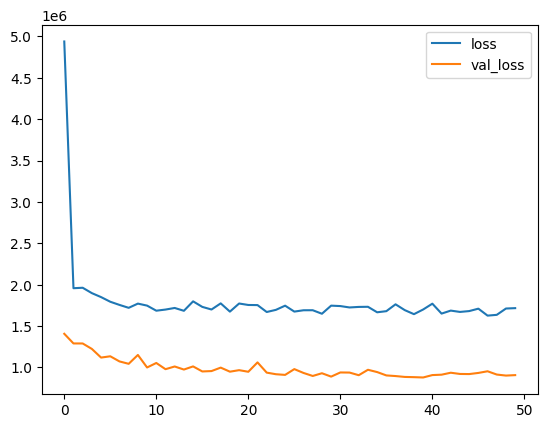

In [103]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [104]:
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
1599940.75

Train data evaluation:
671792.375


In [105]:
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,Test True Y,Model Predictions
0,3407,3414.003906
1,11631,10464.986328
2,18741,15320.855469
3,2285,2862.428711
4,648,555.439026
...,...,...
8086,1985,1860.522095
8087,475,625.322510
8088,2351,2196.041748
8089,945,1208.714478


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

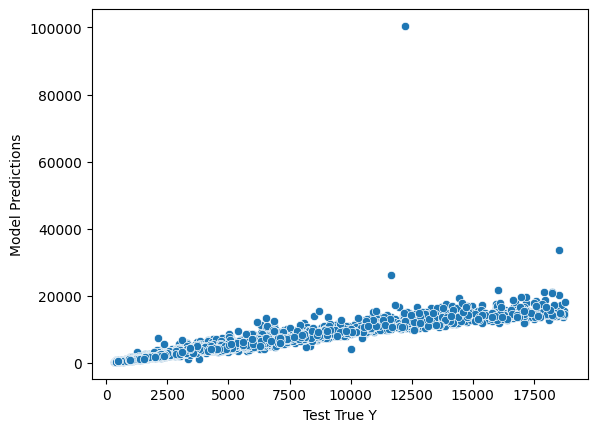

In [106]:
# these values follow a linear line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

According to the scatterplot: the more expensive the diamonds get, the less accurate the predictions get. This does make some sense, since the higher the price range, the less people seem to care about the actual quality details.

In [107]:
 # MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
427.76 $

MSE
1599940.87 $^2

RMSE:
1264.89 $

R-squared:
0.9

Explained variance score:
0.9


C:\Users\Startklar\AppData\Local\Temp\ipykernel_79584\3124900743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


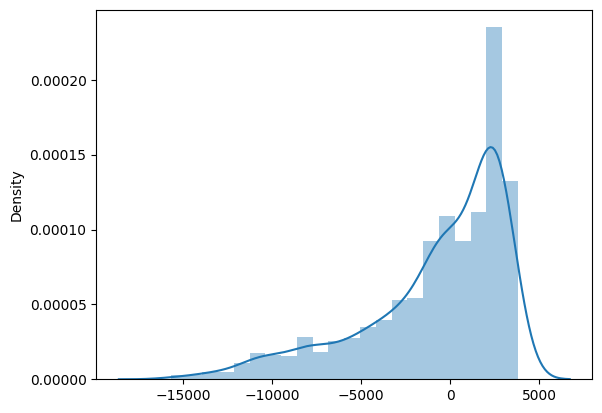

In [108]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

In [109]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,4,5,1,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,5,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,5,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,1,3,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,0,1,63.3,58.0,335,4.34,4.35,2.75


In [110]:
# let's try with some new imaginary data
# this example uses the student performance index score dataset
# modify this as needed regarding your own dataset
tester_row = {
            'carat':    0.25,
            'cut' :      3,
            'color':      3,
            'clarity' :   4,
            'depth' :     68.6, # => 2 * z / (x + y) * 100
            'table'  :    62.5,
            'x'   :       4.1,
            'y'  :        4.15,
            'z' :         2.83
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

In [111]:
result = model.predict(tester_row)[0]

print()
print(f"Estimated price for this diamond:")
print(f"{round(float(result[0]), 2)} $")
print("----------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

Estimated price for this diamond:
777.16 $
----------------


In [112]:
len(y_test)

8091

### Third model

In [147]:
# Define Sequential neural network model
# modify the input shape to match your training column count
# remember, one of the columns is removed from training columns
# to be the target value. so if your data originally had 10 columns
# the input shape is 9 ... (10 - 1 => 9)
# the input layer itself can have a different number of nodes
# Tip: have at least the same number of nodes as in the input shape
# output layer in regression is always 1 node without activation function
model = keras.Sequential(
    [
        layers.Dense(64, input_shape=(variable_amount,), activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.1)),  # 1st layer with 64 neurons
        layers.Dropout(0.1),  # Add dropout to avoid overfitting
        layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.1)),  # 2nd layer with more neurons to learn complex patterns
        layers.Dropout(0.1),  # Dropout again
        layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.1)),  # 3rd layer reduces neuron count
        layers.Dense(1)  # Output layer for regression
    ]
)

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
model.compile(optimizer='adam', loss='mse')

# common tips on how to change neural network structure if your metrics are not good:

# make wider (or narrower) layers (for example, 64 or 128 nodes)
# make a longer or shorter network (add or remove layers)
# use Dropout -layers (e.g. layers.Dropout(0.1))

# remember: there's no process or mathematical formula
# in order to figure out the optimal neural network structure
# it's mostly all about trial and error => EXPERIMENTATION!

# remember to have enough "decision-space" for your data!
# it's highly unlikely a dataset with 20 different variables is going
# to work well with only 8 nodes in each layer etc.

# print out the summary of your model
model.summary()

c:\Users\Startklar\Documents\Study\Finnilandi\DeepLearning\DPierdiluca_DL-Repo\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,281 (67.50 KB)

 Trainable params: 17,281 (67.50 KB)

 Non-trainable params: 0 (0.00 B)

In [148]:
model.fit(x=X_train, y=y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 15041702.0000 - val_loss: 1294142.6250
Epoch 2/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1248475.2500 - val_loss: 1214046.6250
Epoch 3/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1138340.8750 - val_loss: 1245557.2500
Epoch 4/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1230752.0000 - val_loss: 1262600.2500
Epoch 5/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1076082.2500 - val_loss: 1278186.6250
Epoch 6/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1010240.0000 - val_loss: 1304133.5000
Epoch 7/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 1016875.1250 - val_loss: 1321954.8750
Epoch 8/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 982832.6250 - val_loss: 1226527.1250
Epoch 9/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1067126.6250 - val_loss: 1277761.2500
Epoch 10/50
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1087616.0000 - val_loss: 1378034.2500

<Axes: >

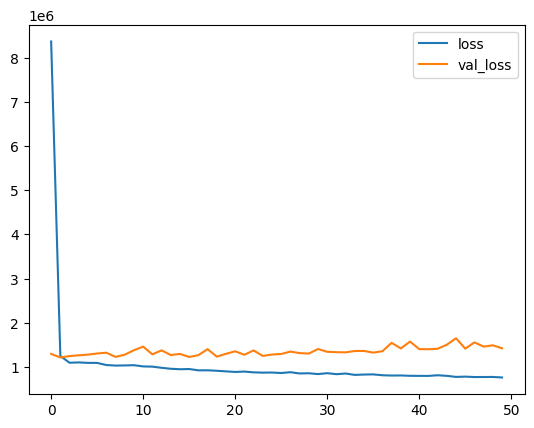

In [149]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [150]:
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
714731.375

Train data evaluation:
625403.4375


In [151]:
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Test True Y,Model Predictions
0,3407,3322.217285
1,11631,11688.617188
2,18741,15127.363281
3,2285,2483.958496
4,648,492.022003
...,...,...
8086,1985,1765.127930
8087,475,554.028076
8088,2351,2000.120850
8089,945,1284.854004


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

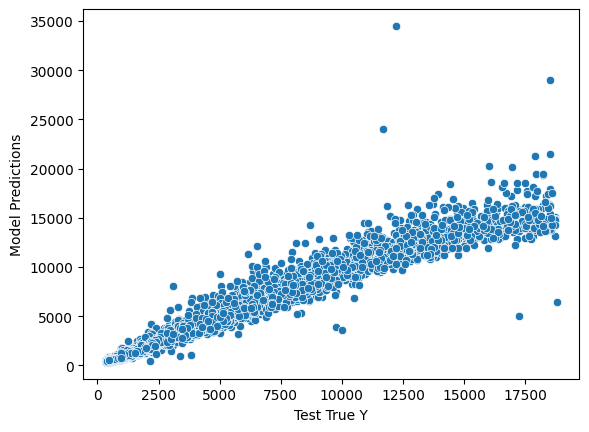

In [152]:
# these values follow a linear line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

According to the scatterplot: the more expensive the diamonds get, the less accurate the predictions get. This does make some sense, since the higher the price range, the less people seem to care about the actual quality details.

In [153]:
 # MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
436.33 $

MSE
714351.72 $^2

RMSE:
845.19 $

R-squared:
0.96

Explained variance score:
0.96


C:\Users\Startklar\AppData\Local\Temp\ipykernel_79584\3124900743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


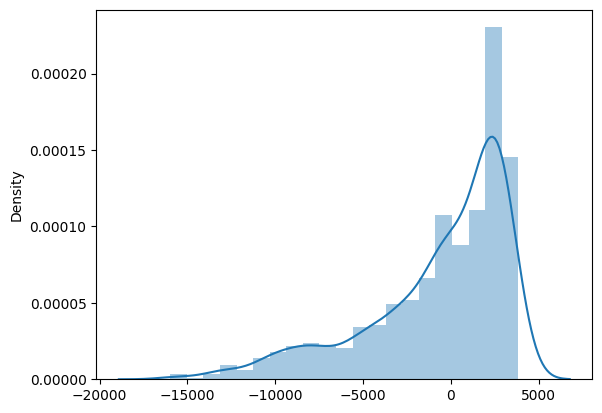

In [154]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

In [155]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,4,5,1,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,5,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,5,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,1,3,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,0,1,63.3,58.0,335,4.34,4.35,2.75


In [156]:
# let's try with some new imaginary data
# this example uses the student performance index score dataset
# modify this as needed regarding your own dataset
tester_row = {
            'carat':    0.25,
            'cut' :      3,
            'color':      3,
            'clarity' :   4,
            'depth' :     68.6, # => 2 * z / (x + y) * 100
            'table'  :    62.5,
            'x'   :       4.1,
            'y'  :        4.15,
            'z' :         2.83
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

In [157]:
result = model.predict(tester_row)[0]

print()
print(f"Estimated price for this diamond:")
print(f"{round(float(result[0]), 2)} $")
print("----------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Estimated price for this diamond:
563.88 $
----------------


In [158]:
len(y_test)

8091